In [ ]:
!pip install pyspark
!pip install joblibspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 10.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=8c3d6078ce647c6a669d05655650eb616dec5426f57b95643a5bf5274e51d711
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble
from sklearn.utils import parallel_backend
from joblibspark import register_spark
from sklearn.metrics import mean_absolute_error

In [ ]:
spark = SparkSession.builder.appName("Vu dep trai").config("spark.executor.memory","9g").getOrCreate()
# conf = pyspark.SparkConf().setMaster("spark://node-master:7077")\
#         .setAppName("Vu dep trai")\
#         .set("spark.executor.memory","15g")
# # sc = SparkContext.getOrCreate(conf=conf)
# # spark.stop()
# sc = SparkContext(conf = conf)
# spark = SparkSession(sc)

In [ ]:
## From EDA select important columns
# input_col = ['Store', 'IsHoliday', 'Type', 'Size', 'Week','Dept','Year']
target = 'Weekly_Sales'

In [ ]:
df_clean = spark.read.csv('train_final.csv', header=True, inferSchema=True)

In [ ]:
# split 80% first data for training
df_train, df_valid = df_clean.randomSplit([0.8, 0.2], seed=1234)
input_col = df_train.columns

In [ ]:
input_col.remove('_c0')
input_col.remove('Weekly_Sales')
input_col.remove('MarkDown1')
input_col.remove('MarkDown2')
input_col.remove('MarkDown3')
input_col.remove('MarkDown4')
input_col.remove('MarkDown5')
input_col.remove('Type')
input_col.remove('Temperature')
input_col.remove('Fuel_Price')
input_col.remove('IsSuperbowl')
input_col.remove('IsLabor')
input_col.remove('IsHoliday')

In [ ]:
df_train_pd = df_train.toPandas()
df_valid_pd = df_valid.toPandas()

In [ ]:
df_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337655 entries, 0 to 337654
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   _c0             337655 non-null  int32  
 1   Store           337655 non-null  int32  
 2   IsHoliday       337655 non-null  int32  
 3   Dept            337655 non-null  int32  
 4   Weekly_Sales    337655 non-null  float64
 5   Temperature     337655 non-null  float64
 6   Fuel_Price      337655 non-null  float64
 7   MarkDown1       120786 non-null  float64
 8   MarkDown2       89276 non-null   float64
 9   MarkDown3       109937 non-null  float64
 10  MarkDown4       108177 non-null  float64
 11  MarkDown5       121385 non-null  float64
 12  CPI             337655 non-null  float64
 13  Unemployment    337655 non-null  float64
 14  Type            337655 non-null  object 
 15  Size            337655 non-null  int32  
 16  Year            337655 non-null  int32  
 17  Month     

In [ ]:
print(df_train_pd.shape)
print(df_valid_pd.shape)

(337655, 26)
(83915, 26)


In [ ]:
df_train_pd.replace("NA",np.NaN,inplace = True)
df_valid_pd.replace("NA",np.NaN,inplace = True)
df_train_pd.fillna(0,inplace=True)
df_valid_pd.fillna(0,inplace=True)

In [ ]:
weight_train = df_train_pd.IsHoliday.map({0:1,1:5})
weight_valid = df_valid_pd.IsHoliday.map({0:1,1:5})

In [ ]:
print(df_train_pd.shape)
print(df_valid_pd.shape)

(337655, 26)
(83915, 26)


In [ ]:
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
register_spark()


scaler = StandardScaler()
scaler.fit_transform(df_train_pd[input_col])
rnd = sklearn.ensemble.RandomForestRegressor()

grid_param = {
    'max_depth': [25, 30, 35],
    'max_features': [1.0, 0.9, 0.8],
    'max_samples': [0.5, 0.75, 1.0]
}

# simulate grid search
# grid_param = {
#     'max_depth': [30],
#     'max_features': [1.0],
#     'max_samples': [0.8, 0.9]
# }

def score_f(y_true, y_pred, sample_weight):
    return mean_absolute_error(y_true.values, y_pred,
                    sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1),)

score_params = {"sample_weight": weight_train}
my_scorer = make_scorer(score_f,
                        greater_is_better=False, 
                        **score_params)

with parallel_backend('spark'):
    grid_search = GridSearchCV(estimator=rnd,
                               param_grid=grid_param,
                               scoring=my_scorer,
                               cv=3,
                               n_jobs=9,
                               verbose=2)
    grid_search.fit(df_train_pd[input_col], df_train_pd[target])


/usr/local/lib/python3.8/dist-packages/joblibspark/backend.py:108: UserWarning: User-specified n_jobs (9) is greater than the max number of concurrent tasks (2) this cluster can run now.If dynamic allocation is enabled for the cluster, you might see more executors allocated.
  warnings.warn(f"User-specified n_jobs ({n_jobs}) is greater than the max number of "


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


In [ ]:
grid_search.best_params_

{'max_depth': 30, 'max_features': 1.0, 'max_samples': 0.8}

In [ ]:
y_pred = grid_search.predict(scaler.transform(df_train_pd[input_col]))
mean_absolute_error(df_train_pd[target], y_pred,sample_weight=weight_train)

726.8036930205452

In [ ]:
y_pred = grid_search.predict(scaler.transform(df_valid_pd[input_col]))
mean_absolute_error(df_valid_pd[target], y_pred,sample_weight=  weight_valid)

1575.8963900228282

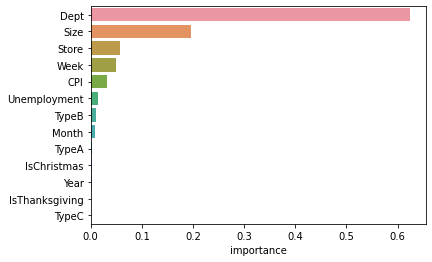

In [ ]:
importance = grid_search.best_estimator_.feature_importances_
importance = pd.DataFrame(importance, index=input_col, columns=["importance"])
importance = importance.sort_values(by="importance", ascending=False)
sns.barplot(y=importance.index, x=importance["importance"], orient = 'h')

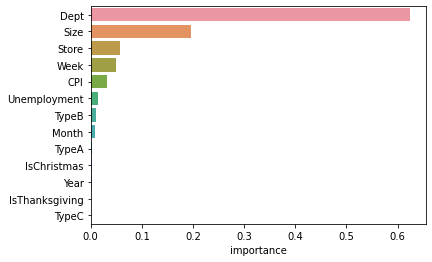

In [ ]:
importance = grid_search.best_estimator_.feature_importances_
importance = pd.DataFrame(importance, index=input_col, columns=["importance"])
importance = importance.sort_values(by="importance", ascending=False)
sns.barplot(y=importance.index, x=importance["importance"], orient = 'h')